# Style transfer using GAN
This notebook will be used to prepare the capstone project 'Style transfer using GAN'

In [35]:
#Import all the required libraries

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from skimage.transform import resize
from keras.utils.vis_utils import plot_model
import imageio
import glob
import cv2
import os
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array

In [36]:
#!unzip '/content/MRI Dataset.zip'

## Data understanding
Import the images & create two seperate datasets. The input shape for image should be (256, 256)


In [73]:
def load_images_from_folder(folder):
    data_list = list()
    for filename in os.listdir(folder):
        image = load_img(folder+filename,target_size = (256,256),color_mode="grayscale")
        image= img_to_array(image)
        data_list.append(image)
    return np.asarray(data_list)

In [74]:
tr1_path = '/content/MRI+T1_T2+Dataset/Tr1/TrainT1/'
tr2_path = '/content/MRI+T1_T2+Dataset/Tr2/TrainT2/'


In [75]:
tr1 = load_images_from_folder(tr1_path)
tr1 = tf.convert_to_tensor(tr1)

In [76]:
tr2 = load_images_from_folder(tr2_path)
tr2 = tf.convert_to_tensor(tr2)


## Image Processing 
1.Create a function to process your images with normalisation

2.Apply the function to both the datasets 

3.Visualise the MRI images after processing




In [77]:
# normalizing the images to [-1, 1]
def normalize(image):
    image = (image/127.5)-1.0
    return image

In [78]:
def preprocess_image_train(image):
    image = tf.image.random_flip_left_right(image)
    image = normalize(image)
    return image

In [79]:
BATCH_SIZE = 32
tr1 = tf.data.Dataset.from_tensor_slices(tr1).shuffle(tr1.shape[0], seed=42).batch(BATCH_SIZE)
tr2 = tf.data.Dataset.from_tensor_slices(tr2).shuffle(tr2.shape[0], seed=42).batch(BATCH_SIZE)

In [80]:
# process both classes of MRI images
AUTOTUNE = tf.data.experimental.AUTOTUNE
tr1 = tr1.map(preprocess_image_train, num_parallel_calls=AUTOTUNE)
tr2 = tr2.map(preprocess_image_train, num_parallel_calls=AUTOTUNE)



In [84]:
sample_tr1 = next(iter(tr1))
sample_tr2 = next(iter(tr2))
sample_tr1.shape

TensorShape([32, 256, 256, 1])

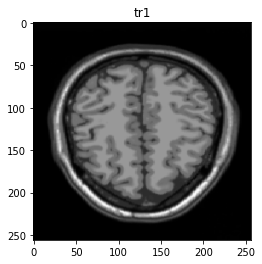

In [85]:
plt.title('tr1')
plt.imshow(sample_tr1[0].numpy()[:, :, 0] * 0.5 + 0.5, cmap='gray')

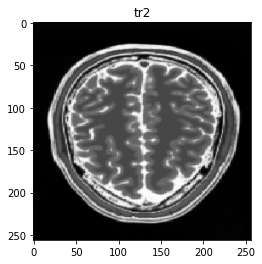

In [86]:
plt.title('tr2')
plt.imshow(sample_tr2[0].numpy()[:, :, 0] * 0.5 + 0.5, cmap='gray')

## Model Building & Training
The architecture of generator is a modified U-Net.

1.Create your Generator & Discriminator

2.Define the loss functions

3.Create the train_step function

In [91]:
class InstanceNormalization(tf.keras.layers.Layer):
    def __init__(self, epsilon=1e-5):
        super(InstanceNormalization, self).__init__()
        self.epsilon = epsilon
    def build(self, input_shape):
        self.scale = self.add_weight(
            name='scale',
            shape=input_shape[-1:],
            initializer=tf.random_normal_initializer(1., 0.02),
            trainable=True)
        self.offset = self.add_weight(
            name='offset',
            shape=input_shape[-1:],
            initializer='zeros',
            trainable=True)
    def call(self, x):
        mean, variance = tf.nn.moments(x, axes=[1, 2], keepdims=True)
        inv = tf.math.rsqrt(variance + self.epsilon)
        normalized = (x - mean) * inv
        return self.scale * normalized + self.offset

def downsample(filters, size, apply_norm=True):
    initializer = tf.random_normal_initializer(0., 0.02)
    result = tf.keras.Sequential()
    result.add(tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                                      kernel_initializer=initializer, use_bias=False))
    if apply_norm:
        result.add(InstanceNormalization())
    result.add(tf.keras.layers.LeakyReLU())
    return result

def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)
    result = tf.keras.Sequential()
    result.add(tf.keras.layers.Conv2DTranspose(filters, size, strides=2, padding='same',
                                               kernel_initializer=initializer, use_bias=False))
    result.add(InstanceNormalization())
    if apply_dropout:
        result.add(tf.keras.layers.Dropout(0.5))
    result.add(tf.keras.layers.ReLU())
    return result

In [92]:
def unet_generator():
    down_stack = [
        downsample(64, 4, False), #128
        downsample(128, 4), #164
        downsample(128, 4), #32
        downsample(128, 4), #16
        downsample(256, 4), #8
        downsample(256, 4), #4
        downsample(256, 4), #2
        downsample(256, 4), #1
        ]  
    
    up_stack = [
        upsample(256, 4, apply_dropout=True), #2
        upsample(256, 4), #4
        upsample(256, 4), #8
        upsample(128, 4), #32
        upsample(128, 4), #64
        upsample(128, 4), #128
        upsample(64, 4), #256
    ]
    initializer = tf.random_normal_initializer(0., 0.02)
    last = tf.keras.layers.Conv2DTranspose(1, 4, strides=2, padding='same', kernel_initializer=initializer,
                                           activation='tanh') # (bs, 256, 256, 1)
    concat = tf.keras.layers.Concatenate()
    inputs = tf.keras.layers.Input(shape=[256,256, 1])
    x = inputs
    # Downsampling through the model
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)
    skips = reversed(skips[:-1])
    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = concat([x, skip])
    x = last(x)
    return tf.keras.Model(inputs=inputs, outputs=x)

In [93]:
generator_g = unet_generator()#initialise the generator
generator_f = unet_generator()#initialise the generator

In [94]:
generator_g.summary()

Model: "model_10"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 256, 256, 1) 0                                            
__________________________________________________________________________________________________
sequential_110 (Sequential)     (None, 128, 128, 64) 1024        input_7[0][0]                    
__________________________________________________________________________________________________
sequential_111 (Sequential)     (None, 64, 64, 128)  131328      sequential_110[0][0]             
__________________________________________________________________________________________________
sequential_112 (Sequential)     (None, 32, 32, 128)  262400      sequential_111[0][0]             
___________________________________________________________________________________________

In [95]:
def discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)
    inp = tf.keras.layers.Input(shape=[256, 256, 1], name='input_image')
    x = inp
    down1 = downsample(64, 4,  False)(x)  #write your code to downsample X
    down2 = downsample(128, 4)(down1)     #write your code to downsample down1
    down3 = downsample(256, 4)(down2)     #write your code to downsample down2
    down4 = downsample(256, 4)(down3)
    down5 = downsample(256, 4)(down4)
    zero_pad1 = tf.keras.layers.ZeroPadding2D()(down5) # (bs, 34, 34, 256)
    conv = tf.keras.layers.Conv2D(512, 4, strides=1, kernel_initializer=initializer,
                                  use_bias=False)(zero_pad1) # (bs, 31, 31, 512)
    norm1 = InstanceNormalization()(conv)
    leaky_relu = tf.keras.layers.LeakyReLU()(norm1)
    zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu) # (bs, 33, 33, 512)
    last = tf.keras.layers.Conv2D(1, 4, strides=1, kernel_initializer=initializer)(zero_pad2) # (bs, 30, 30, 1)
    return tf.keras.Model(inputs=inp, outputs=last)#create the model using input & output layer

In [96]:
discriminator_x = discriminator()#initialise the discriminator
discriminator_y = discriminator()#initialise the discriminator

In [97]:
discriminator_x.summary()

Model: "model_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_image (InputLayer)     [(None, 256, 256, 1)]     0         
_________________________________________________________________
sequential_140 (Sequential)  (None, 128, 128, 64)      1024      
_________________________________________________________________
sequential_141 (Sequential)  (None, 64, 64, 128)       131328    
_________________________________________________________________
sequential_142 (Sequential)  (None, 32, 32, 256)       524800    
_________________________________________________________________
sequential_143 (Sequential)  (None, 16, 16, 256)       1049088   
_________________________________________________________________
sequential_144 (Sequential)  (None, 8, 8, 256)         1049088   
_________________________________________________________________
zero_padding2d_8 (ZeroPaddin (None, 10, 10, 256)       0  

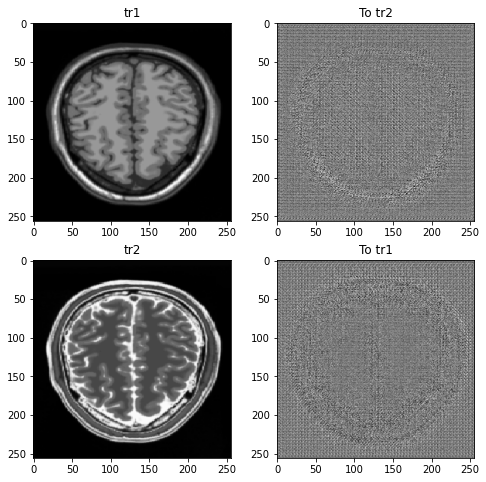

In [98]:
to_tr2 = generator_g(sample_tr1)
to_tr1 = generator_f(sample_tr2)
plt.figure(figsize=(8, 8))
contrast = 8

imgs = [sample_tr1, to_tr2, sample_tr2, to_tr1]
title = ['tr1', 'To tr2', 'tr2', 'To tr1']

for i in range(len(imgs)):
    plt.subplot(2, 2, i+1)
    plt.title(title[i])
    if i % 2 == 0:
        plt.imshow(imgs[i][0].numpy()[:, :, 0] * 0.5 + 0.5, cmap='gray')
    else:
        plt.imshow(imgs[i][0].numpy()[:, :, 0] * 0.5 * contrast + 0.5, cmap='gray')
plt.show()

In [99]:
LAMBDA = 125.0

In [100]:
loss_obj =  tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [101]:
def discriminator_loss(real, generated):
    real_loss = loss_obj(tf.ones_like(real), real)
    generated_loss = loss_obj(tf.zeros_like(generated), generated)
    total_disc_loss = real_loss + generated_loss
    return total_disc_loss * 0.5

In [102]:
def generator_loss(generated):
    return loss_obj(tf.ones_like(generated), generated)

In [103]:
def calc_cycle_loss(real_image, cycled_image):
    loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))#write your code here
    return LAMBDA * loss1

In [104]:
def identity_loss(real_image, same_image):
    loss = tf.reduce_mean(tf.abs(real_image - same_image))
    return 0.5 * loss

In [105]:
generator_g_optimizer = tf.keras.optimizers.Adam(0.0001, beta_1=0.5)
generator_f_optimizer = tf.keras.optimizers.Adam(0.0001, beta_1=0.5)

discriminator_x_optimizer = tf.keras.optimizers.Adam(0.0001, beta_1=0.5)
discriminator_y_optimizer = tf.keras.optimizers.Adam(0.0001, beta_1=0.5)

In [113]:
EPOCHS =125

In [107]:
checkpoint_path = "./Trained_Models"

ckpt = tf.train.Checkpoint(generator_g=generator_g,
                           generator_f=generator_f,
                           discriminator_x=discriminator_x,
                           discriminator_y=discriminator_y,
                           generator_g_optimizer=generator_g_optimizer,
                           generator_f_optimizer=generator_f_optimizer,
                           discriminator_x_optimizer=discriminator_x_optimizer,
                           discriminator_y_optimizer=discriminator_y_optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=3)

# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print ('Latest checkpoint restored!!')

In [108]:
def generate_images(model, test_input, expected_output):
    prediction = model(test_input)
    plt.figure(figsize=(10, 10))
    display_list = [test_input[0], prediction[0], expected_output[0]]
    title = ['Input Image', 'Predicted Image', 'Expected Image']
    for i in range(3):
        plt.subplot(1, 3, i+1)
        plt.title(title[i])
        # getting the pixel values between [0, 1] to plot it.
        plt.imshow(display_list[i].numpy()[:, :, 0] * 0.5 + 0.5, cmap='gray')
        plt.axis('off')
    plt.show()

In [109]:
@tf.function
def train_step(real_x, real_y):
    # persistent is set to True because the tape is used more than
    # once to calculate the gradients.
    with tf.GradientTape(persistent=True) as tape:
        # Generator G translates X -> Y
        # Generator F translates Y -> X.
        fake_y = generator_g(real_x, training=True)#write your code to generate images using Generator_g on real_x
        cycled_x = generator_f(fake_y, training=True)#write your code to generate images susiing Generator_f on fake_y
        
        fake_x = generator_f(real_y, training=True)#write your code to generate images using Generator_f on real_y
        cycled_y = generator_g(fake_x, training=True)#write your code to generate images using Generator_g on fake_x
        
        # same_x and same_y are used for identity loss.
        same_x = generator_f(real_x, training=True)#write your code to generate images using Generator_f on real_x
        same_y = generator_g(real_y, training=True)#write your code to generate images using Generator_g on real_y
        
        disc_real_x = discriminator_x(real_x, training=True)#write your code to discriminate images using Discriminator_x on real_x
        disc_real_y = discriminator_y(real_y, training=True)#write your code to discriminate images using Discriminator_y on real_y
        
        disc_fake_x = discriminator_x(fake_x, training=True)#write your code to discriminate images using Discriminator_x on fake_x
        disc_fake_y =discriminator_y(fake_y, training=True) #write your code to discriminate images using Discriminator_y on fake_y
        
        # calculate the loss
        gen_g_loss =generator_loss(disc_fake_y) # calculate the generator_loss for disc_fake_
        gen_f_loss = generator_loss(disc_fake_x)# calculate the generator_loss for disc_fake_X 
        
        total_cycle_loss = calc_cycle_loss(real_x, cycled_x) + calc_cycle_loss(real_y, cycled_y)#calculate the total cycle loss
        
        # Total generator loss = adversarial loss + cycle loss
        total_gen_g_loss = gen_g_loss + total_cycle_loss + identity_loss(real_y, same_y)
        total_gen_f_loss = gen_f_loss + total_cycle_loss + identity_loss(real_x, same_x)
        
        disc_x_loss = discriminator_loss(disc_real_x, disc_fake_x)# calculate the discriminator_loss for disc_fake_x wrt disc_real_x
        disc_y_loss =discriminator_loss(disc_real_y, disc_fake_y) # calculate the discriminator_loss foor disc_fake_y wrt disc_real_y
        
    # Calculate the gradients for generator and discriminator
    generator_g_gradients =tape.gradient(total_gen_g_loss, generator_g.trainable_variables) #write your code here
    generator_f_gradients = tape.gradient(total_gen_f_loss, generator_f.trainable_variables)#write your code here
    
    discriminator_x_gradients =tape.gradient(disc_x_loss, discriminator_x.trainable_variables) #write your code here
    discriminator_y_gradients =tape.gradient(disc_y_loss, discriminator_y.trainable_variables) #write your code here
    
    # Apply the gradients to the optimizer
    
    #write your code here
    generator_g_optimizer.apply_gradients(zip(generator_g_gradients, generator_g.trainable_variables))
    generator_f_optimizer.apply_gradients(zip(generator_f_gradients, generator_f.trainable_variables))
    
    discriminator_x_optimizer.apply_gradients(zip(discriminator_x_gradients, discriminator_x.trainable_variables))
    discriminator_y_optimizer.apply_gradients(zip(discriminator_y_gradients, discriminator_y.trainable_variables))


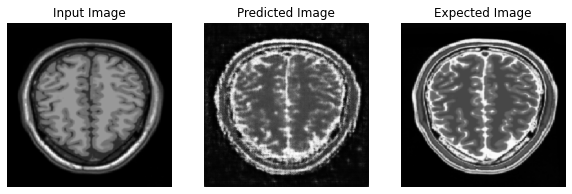

Saving checkpoint for epoch 0 at ./Trained_Models/ckpt-151


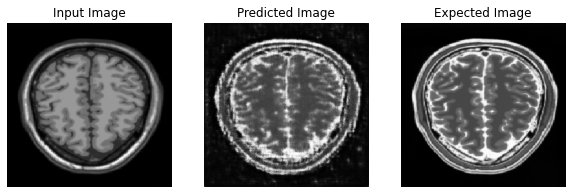

Saving checkpoint for epoch 1 at ./Trained_Models/ckpt-152


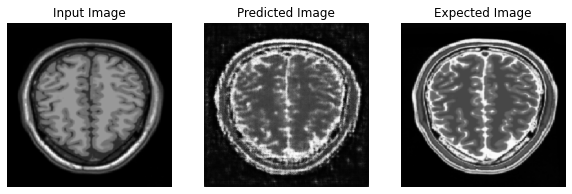

Saving checkpoint for epoch 2 at ./Trained_Models/ckpt-153


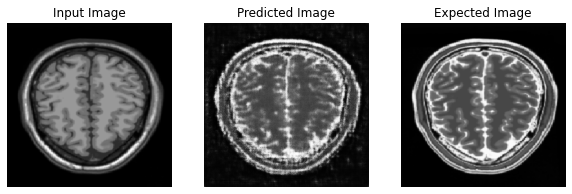

Saving checkpoint for epoch 3 at ./Trained_Models/ckpt-154


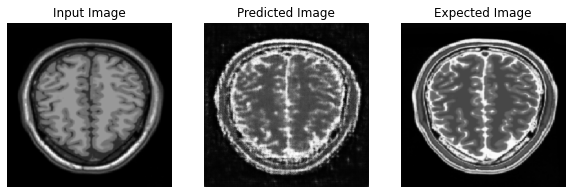

Saving checkpoint for epoch 4 at ./Trained_Models/ckpt-155


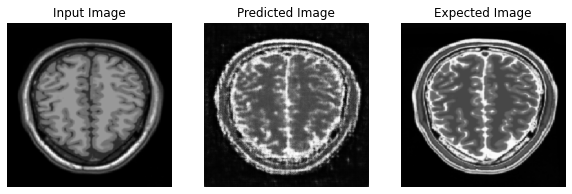

Saving checkpoint for epoch 5 at ./Trained_Models/ckpt-156


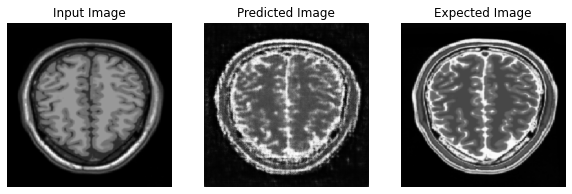

Saving checkpoint for epoch 6 at ./Trained_Models/ckpt-157


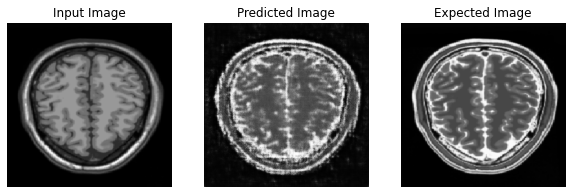

Saving checkpoint for epoch 7 at ./Trained_Models/ckpt-158


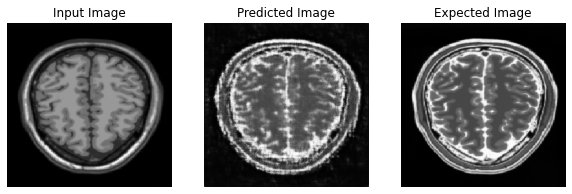

Saving checkpoint for epoch 8 at ./Trained_Models/ckpt-159


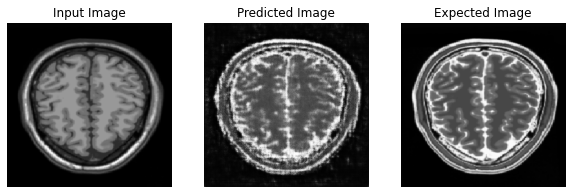

Saving checkpoint for epoch 9 at ./Trained_Models/ckpt-160


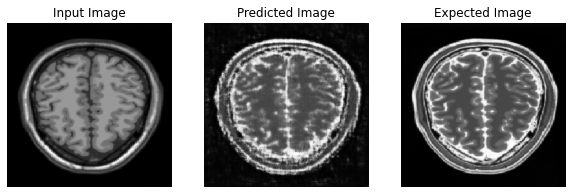

Saving checkpoint for epoch 10 at ./Trained_Models/ckpt-161


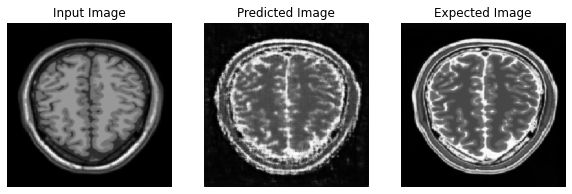

Saving checkpoint for epoch 11 at ./Trained_Models/ckpt-162


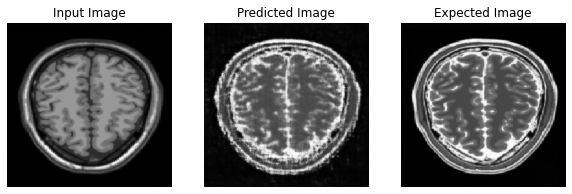

Saving checkpoint for epoch 12 at ./Trained_Models/ckpt-163


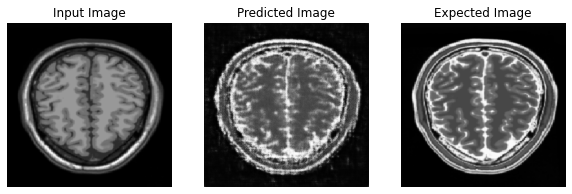

Saving checkpoint for epoch 13 at ./Trained_Models/ckpt-164


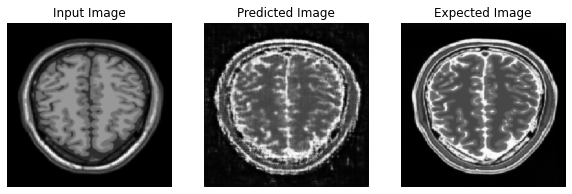

Saving checkpoint for epoch 14 at ./Trained_Models/ckpt-165


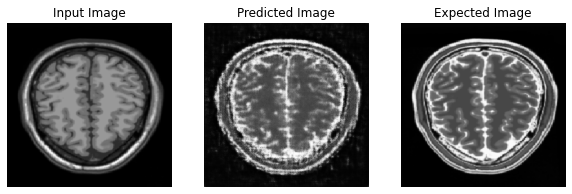

Saving checkpoint for epoch 15 at ./Trained_Models/ckpt-166


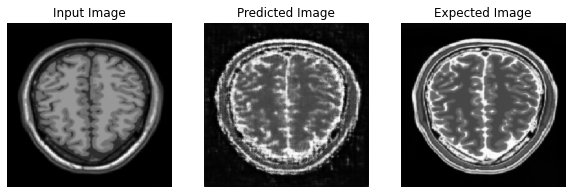

Saving checkpoint for epoch 16 at ./Trained_Models/ckpt-167


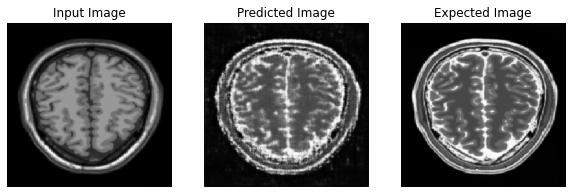

Saving checkpoint for epoch 17 at ./Trained_Models/ckpt-168


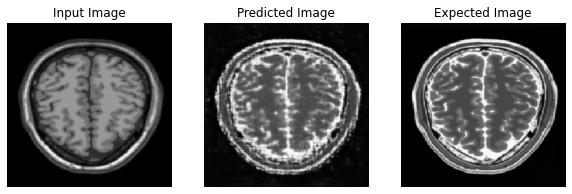

Saving checkpoint for epoch 18 at ./Trained_Models/ckpt-169


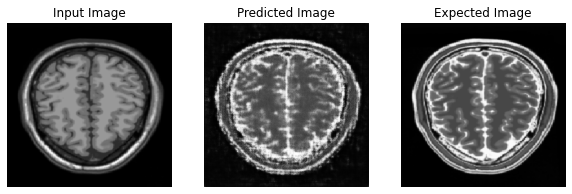

Saving checkpoint for epoch 19 at ./Trained_Models/ckpt-170


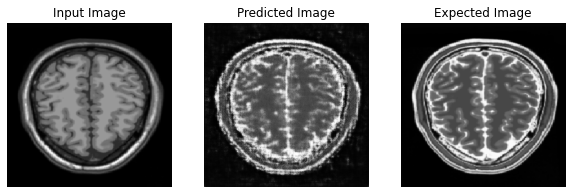

Saving checkpoint for epoch 20 at ./Trained_Models/ckpt-171


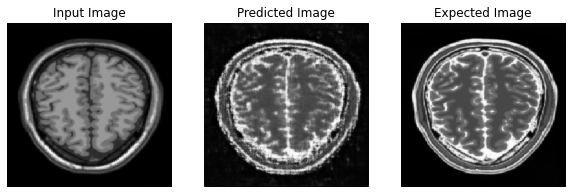

Saving checkpoint for epoch 21 at ./Trained_Models/ckpt-172


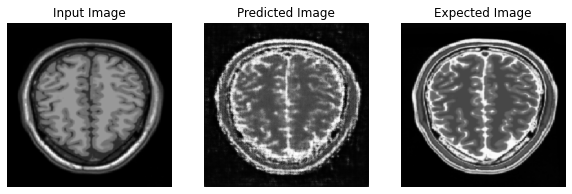

Saving checkpoint for epoch 22 at ./Trained_Models/ckpt-173


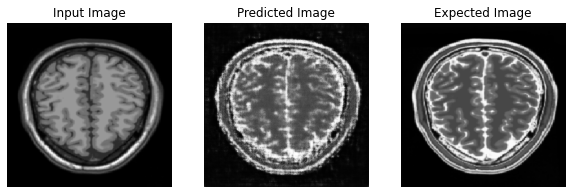

Saving checkpoint for epoch 23 at ./Trained_Models/ckpt-174


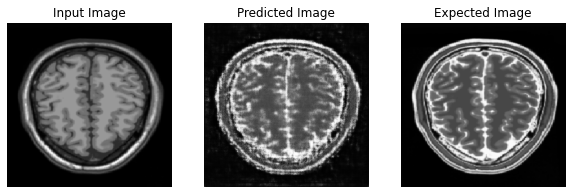

Saving checkpoint for epoch 24 at ./Trained_Models/ckpt-175


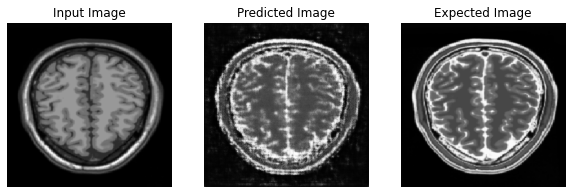

Saving checkpoint for epoch 25 at ./Trained_Models/ckpt-176


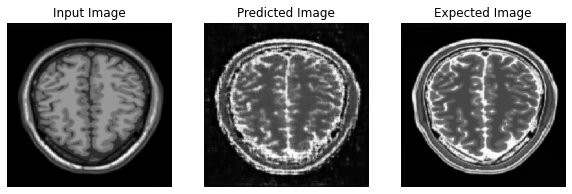

Saving checkpoint for epoch 26 at ./Trained_Models/ckpt-177


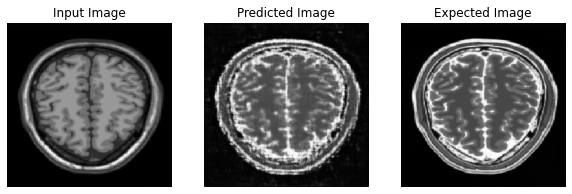

Saving checkpoint for epoch 27 at ./Trained_Models/ckpt-178


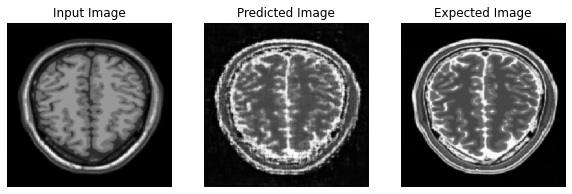

Saving checkpoint for epoch 28 at ./Trained_Models/ckpt-179


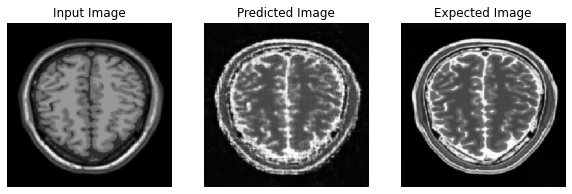

Saving checkpoint for epoch 29 at ./Trained_Models/ckpt-180


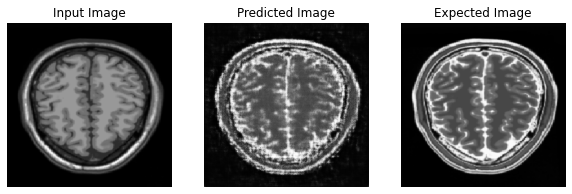

Saving checkpoint for epoch 30 at ./Trained_Models/ckpt-181


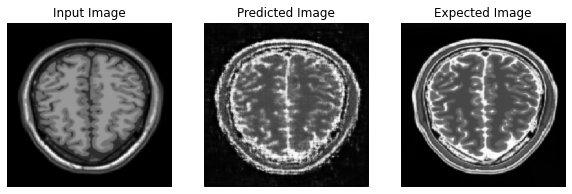

Saving checkpoint for epoch 31 at ./Trained_Models/ckpt-182


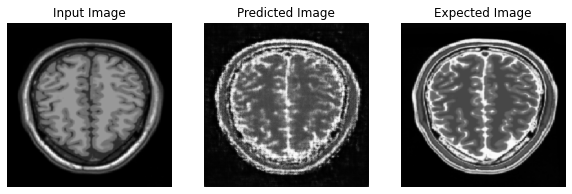

Saving checkpoint for epoch 32 at ./Trained_Models/ckpt-183


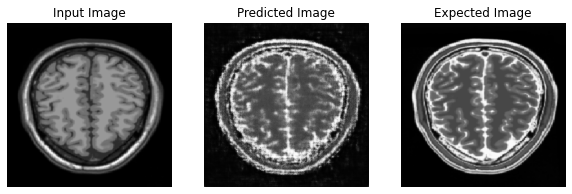

Saving checkpoint for epoch 33 at ./Trained_Models/ckpt-184


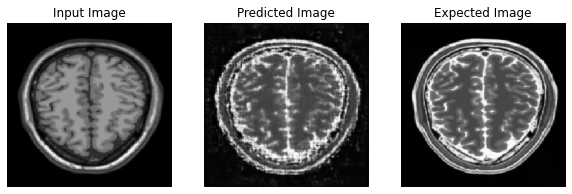

Saving checkpoint for epoch 34 at ./Trained_Models/ckpt-185


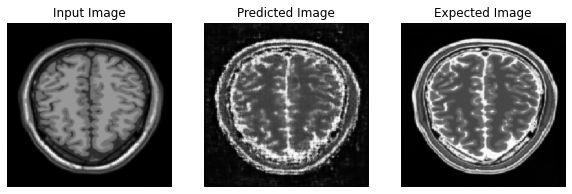

Saving checkpoint for epoch 35 at ./Trained_Models/ckpt-186


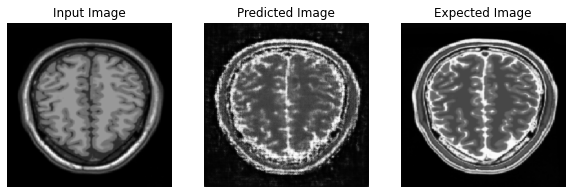

Saving checkpoint for epoch 36 at ./Trained_Models/ckpt-187


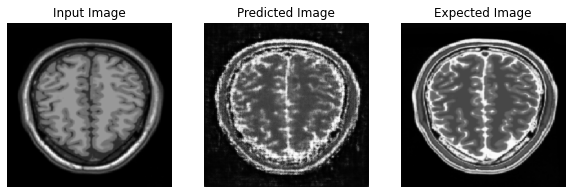

Saving checkpoint for epoch 37 at ./Trained_Models/ckpt-188


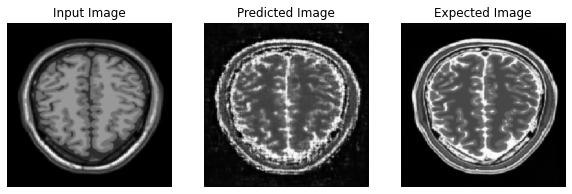

Saving checkpoint for epoch 38 at ./Trained_Models/ckpt-189


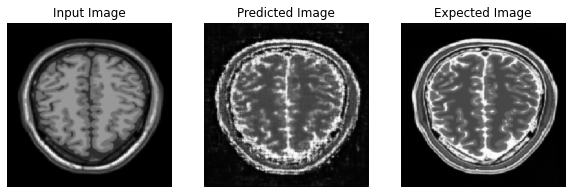

Saving checkpoint for epoch 39 at ./Trained_Models/ckpt-190


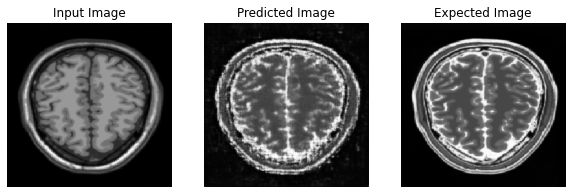

Saving checkpoint for epoch 40 at ./Trained_Models/ckpt-191


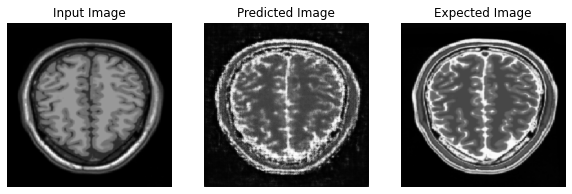

Saving checkpoint for epoch 41 at ./Trained_Models/ckpt-192


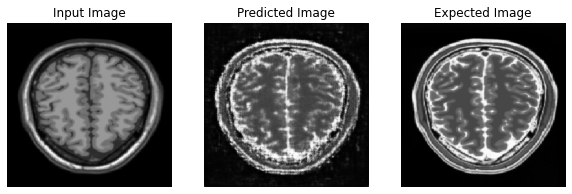

Saving checkpoint for epoch 42 at ./Trained_Models/ckpt-193


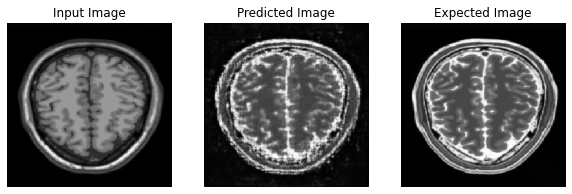

Saving checkpoint for epoch 43 at ./Trained_Models/ckpt-194


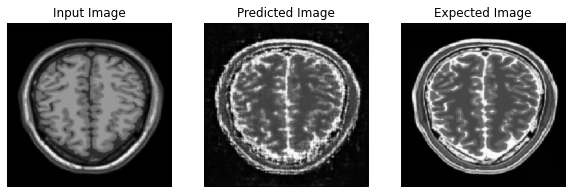

Saving checkpoint for epoch 44 at ./Trained_Models/ckpt-195


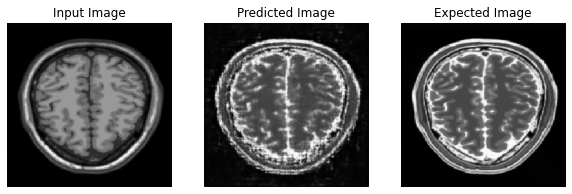

Saving checkpoint for epoch 45 at ./Trained_Models/ckpt-196


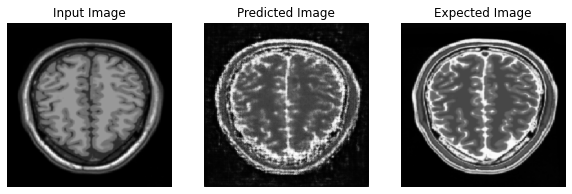

Saving checkpoint for epoch 46 at ./Trained_Models/ckpt-197


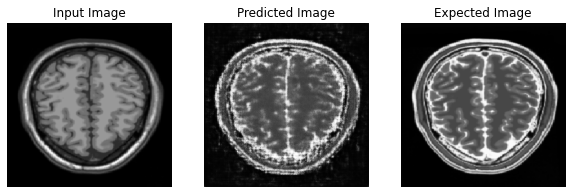

Saving checkpoint for epoch 47 at ./Trained_Models/ckpt-198


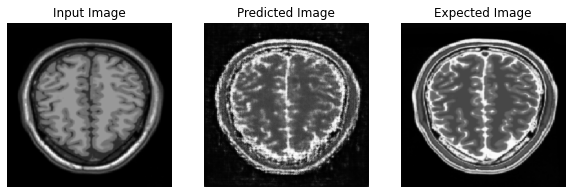

Saving checkpoint for epoch 48 at ./Trained_Models/ckpt-199


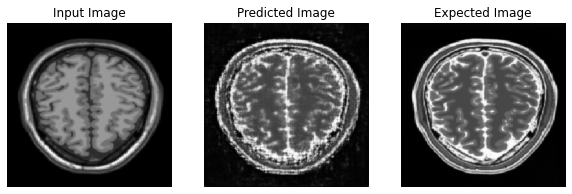

Saving checkpoint for epoch 49 at ./Trained_Models/ckpt-200


In [114]:
for epoch in range(EPOCHS):
    for image_x, image_y in tf.data.Dataset.zip((tr1, tr2)):
        train_step(image_x, image_y)
    generate_images(generator_g, sample_tr1, sample_tr2)
    ckpt_save_path = ckpt_manager.save()
    print('Saving checkpoint for epoch', epoch, 'at', ckpt_save_path)

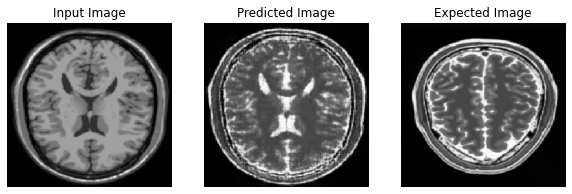

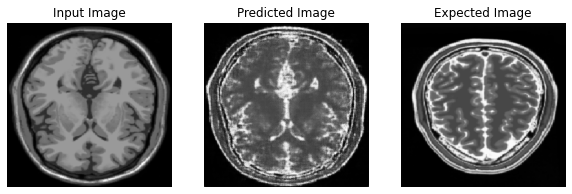

In [115]:
# Run the trained model on the test dataset
for inp in tr1.take(6):
    generate_images(generator_g, inp, sample_tr2)